<a href="https://colab.research.google.com/github/ealeongomez/Deep-Learning/blob/master/RNNS_Presion.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!git clone https://github.com/ealeongomez/Data

Cloning into 'Data'...
remote: Enumerating objects: 35, done.
remote: Counting objects: 100% (35/35), done.
remote: Compressing objects: 100% (31/31), done.
remote: Total 35 (delta 8), reused 0 (delta 0), pack-reused 0
Unpacking objects: 100% (35/35), done.


In [ ]:
cd Data/

/content/Data


In [ ]:
!unzip jena_climate_2009_2016.csv.zip

Archive:  jena_climate_2009_2016.csv.zip
  inflating: jena_climate_2009_2016.csv  
  inflating: __MACOSX/._jena_climate_2009_2016.csv  


In [ ]:
# Basic packages
import pandas as pd 
import matplotlib.pyplot as plt
import numpy as np
import matplotlib as mpl

# Machine learning packages 
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA

# Métricas de rendimiento
from sklearn.metrics import mean_squared_error as mse
from sklearn.metrics import mean_squared_error, mean_absolute_error, mean_squared_log_error, r2_score

# TensorFlow ≥2.0-preview is required
import tensorflow as tf
from tensorflow import keras
assert tf.__version__ >= "2.0"


In [ ]:
def univariate_data(dataset, start_index, end_index, history_size, target_size):
  '''
    INPUT 
      dataset: time serie
      start_index: index of initial 
      end_index: index of end
      history_size: size of windows
      target_size
    OUTPUT:
      X:
      y: 
  '''

  data = []
  labels = []

  start_index = start_index + history_size
  if end_index is None:
    end_index = len(dataset) - target_size

  for i in range(start_index, end_index):
    indices = range(i-history_size, i)
    # Reshape data from (history_size,) to (history_size, 1)
    data.append(np.reshape(dataset[indices], (history_size, 1)))
    labels.append(dataset[i+target_size])

  X = np.array(data)
  y = np.array(labels)

  return X, y

#**Datos secuenciales**

Este tipo de datos, los cuales pueden ser númericos o de texto, son aquellos en los cuales su valor $t$ depende directamante de valores pasados a este. Ahora bien considere una secuencia de datos como:

$$(x_0, x_1, x_2, ..., x_t)$$

Donde los índices indican el orden de la secuencia y $t$ la longitud de esta. Estas secuencias de información son modeladas de mejor manera que las redes neuronales densas mediante las Redes Neuronales Recurrentes, las cuales permiten modelar secuencias debido a:

1. Permiten entradas de longitud variable
2. Rastrean dependencias a largo plazo en los datos.
3. Mantienen información sobre el orden sucuencial.
4. Comparten parámetros en toda la secuencia. 





#**Load data**

In [ ]:
# Import data 
df = pd.read_csv("jena_climate_2009_2016.csv")

# Print dataset
df.head()

,Date Time,p (mbar),T (degC),Tpot (K),Tdew (degC),rh (%),VPmax (mbar),VPact (mbar),VPdef (mbar),sh (g/kg),H2OC (mmol/mol),rho (g/m**3),wv (m/s),max. wv (m/s),wd (deg)
0,01.01.2009 00:10:00,996.52,-8.02,265.40,-8.90,93.3,3.33,3.11,0.22,1.94,3.12,1307.75,1.03,1.75,152.3
1,01.01.2009 00:20:00,996.57,-8.41,265.01,-9.28,93.4,3.23,3.02,0.21,1.89,3.03,1309.80,0.72,1.50,136.1
2,01.01.2009 00:30:00,996.53,-8.51,264.91,-9.31,93.9,3.21,3.01,0.20,1.88,3.02,1310.24,0.19,0.63,171.6
3,01.01.2009 00:40:00,996.51,-8.31,265.12,-9.07,94.2,3.26,3.07,0.19,1.92,3.08,1309.19,0.34,0.50,198.0
4,01.01.2009 00:50:00,996.51,-8.27,265.15,-9.04,94.1,3.27,3.08,0.19,1.92,3.09,1309.00,0.32,0.63,214.3


In [ ]:
data = df['VPmax (mbar)']                       # Conjunto de datos a modelar 
data = data.fillna(df['VPmax (mbar)'].mean())    # Remover los valores nan por la media de los datos

data.index = df['Date Time'] 
data.head()

Date Time
01.01.2009 00:10:00    3.33
01.01.2009 00:20:00    3.23
01.01.2009 00:30:00    3.21
01.01.2009 00:40:00    3.26
01.01.2009 00:50:00    3.27
Name: VPmax (mbar), dtype: float64

In [ ]:
# Normalización de los datos 
timeSerie = data.values
timeSerie = (timeSerie-min(timeSerie))/(max(timeSerie)-min(timeSerie))  

time = np.arange(0, len(timeSerie),1)

X__, y__ = univariate_data(timeSerie, 0, None, 10, 0)

X_, X_test, y_, y_test = train_test_split(X__, y__, test_size=0.20, random_state=42)
X_train, X_valid, y_train, y_valid = train_test_split(X_, y_, test_size=0.20, random_state=42)

X_train.shape, X_valid.shape, X_test.shape

((269145, 10, 1), (67287, 10, 1), (84109, 10, 1))

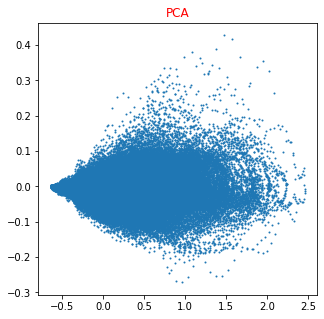

In [ ]:
# Analisis exploratorio de los datos
pca = PCA(n_components = 2)
tranformed_pca = pca.fit_transform(np.squeeze(X__))

plt.figure(figsize=(5, 5))
plt.title("PCA", c='r')
plt.scatter(tranformed_pca[:,0], tranformed_pca[:,1], s=1)
plt.show()

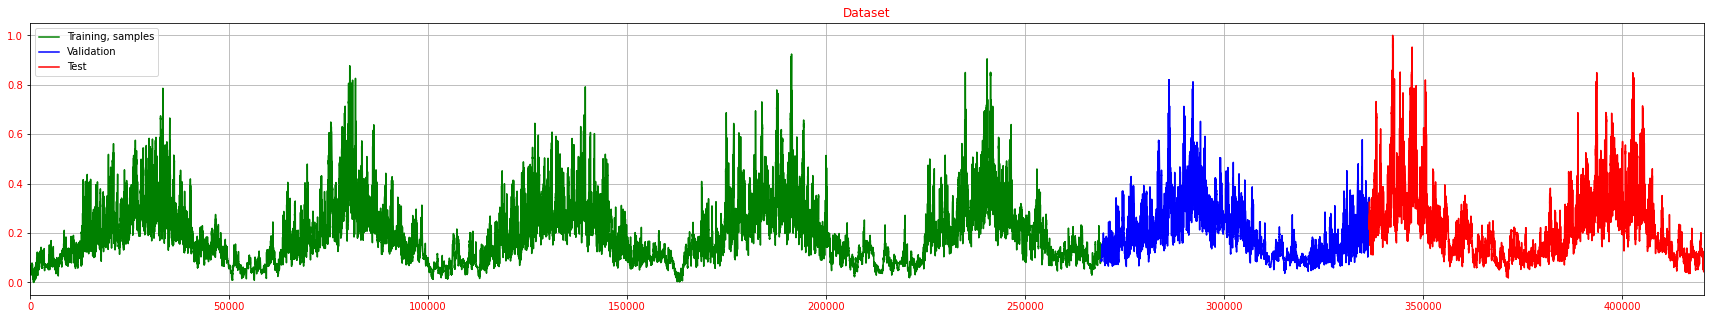

In [ ]:
# Ploter el conjunto de datos 
plt.figure(figsize=(30,5))
plt.plot(time[0:X_train.shape[0]], timeSerie[0:X_train.shape[0]], 'g', label= 'Training, samples')
plt.plot(time[X_train.shape[0]:X_train.shape[0]+X_valid.shape[0]], timeSerie[X_train.shape[0]:X_train.shape[0]+X_valid.shape[0]], 'b', label= 'Validation')
plt.plot(time[X_train.shape[0]+X_valid.shape[0]:], timeSerie[X_train.shape[0]+X_valid.shape[0]:], 'r', label= 'Test')
plt.title('Dataset', c='r')
plt.xticks(c='r')
plt.yticks(c='r')
plt.xlim(0,timeSerie.shape[0])
plt.legend()
plt.grid(True)
plt.show()

#**RNN simple**


1.  **Estado de la neurona**

   si aplicamos una relación de recurrencia en cada paso de tiempo para procesar una secuencia:

$$h_t = f_w (h_{t-1}, x_t) $$

  Donde $ht$ es el estado de la neurona, $f_w$ es la función parametrizadora de $W$, $h_{t-1}$ es el estado anterior y $x_t$ es la entrada. 

*   $h_{t-1}$ es el estado oculto que almacena la información de la secuencia hasta el paso del tiempo $t-1$

2. **Salida del modelo**

$$ \hat{y}_t = W_{hy}^\top h_t $$

3. **Actualización de estado de la neurona**

$$ h_t = tanh \left( W_{nn}^\top h_{t-1} + W^\top_{xh} x_t \right)$$



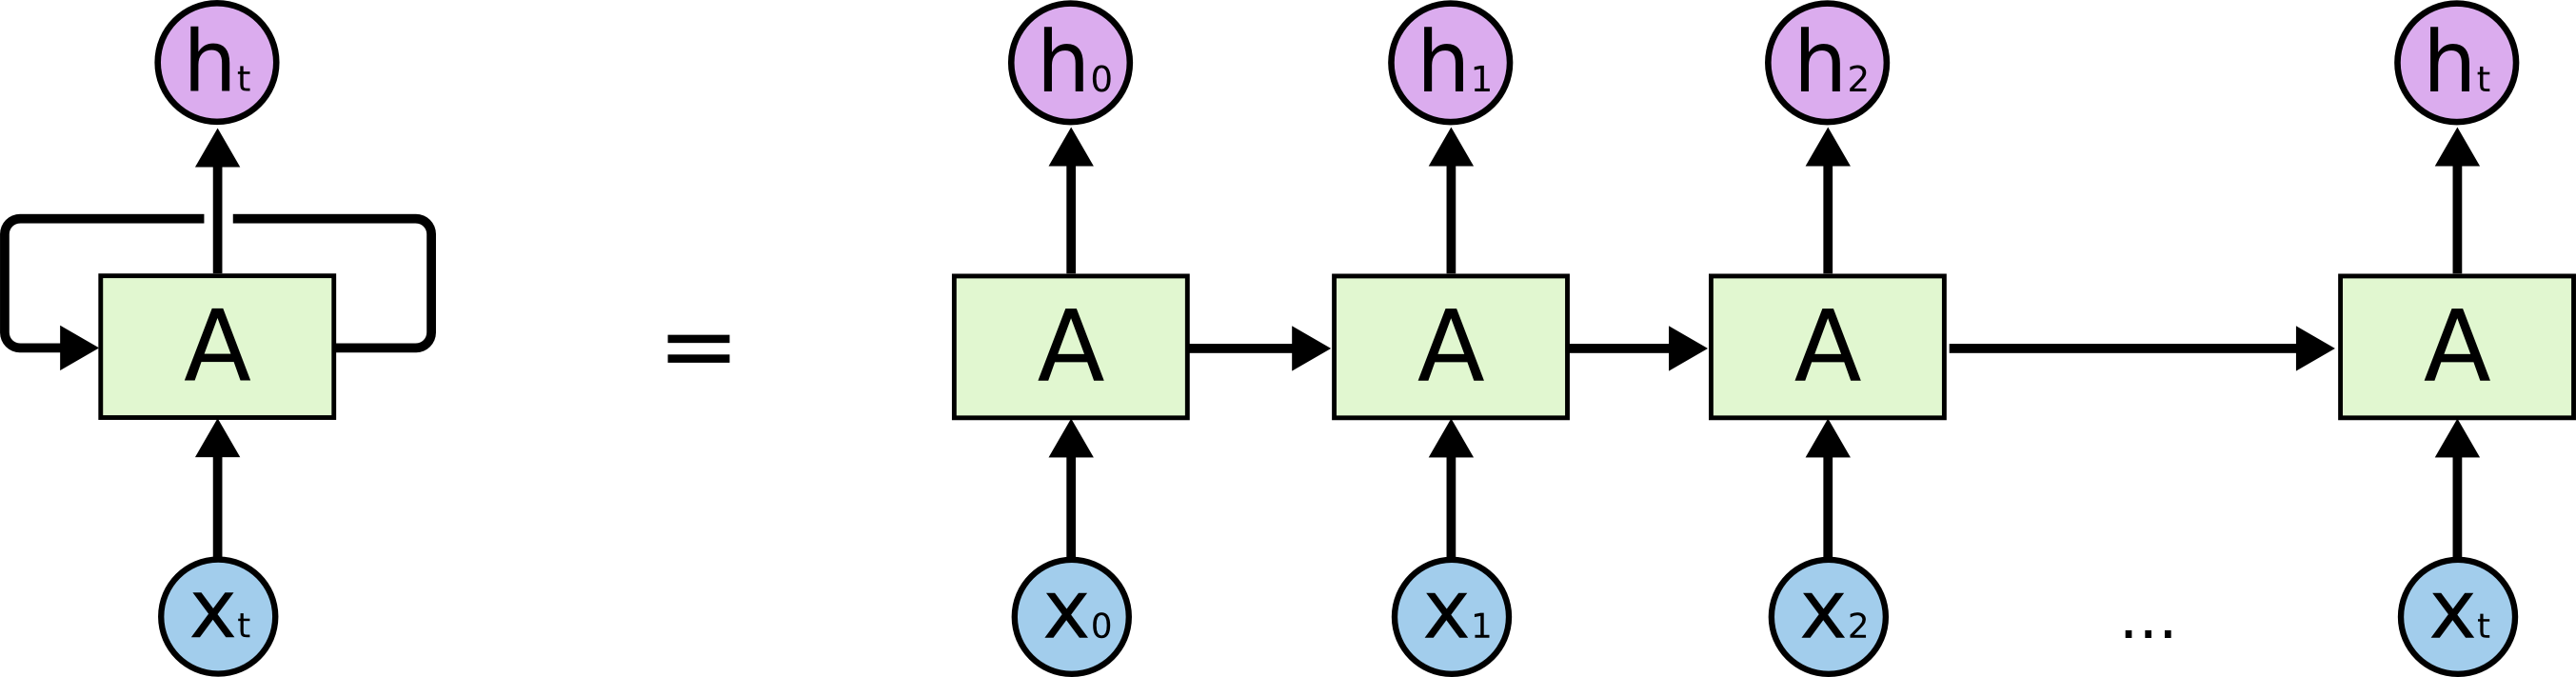


*  **Función de costo**
  - La ecuación de pérdida es la Entropía cruzada, normalmente usada para un problema de clasificacsión binaria

  $$L_t \left( \hat{h}_t, h_t \right) = -h_t log(\hat{h}_t) - \left( 1 - h_t \right) log \left( 1 - \hat{h}_t \right)$$

  - La pérdida se realiza sobre cada una de las neuronas 
  $$L (\hat{h}_t, h_t) = \sum_{t=1}^{T_y} L_t \left( \hat{h}_t, h_t \right) $$



In [ ]:
model = keras.models.Sequential([
    keras.layers.SimpleRNN(10, return_sequences=True, input_shape=[10, 1]),
    keras.layers.SimpleRNN(10, return_sequences=True),
    keras.layers.SimpleRNN(10, return_sequences=True),
    keras.layers.SimpleRNN(1)
])

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
simple_rnn (SimpleRNN)       (None, 10, 10)            120       
_________________________________________________________________
simple_rnn_1 (SimpleRNN)     (None, 10, 10)            210       
_________________________________________________________________
simple_rnn_2 (SimpleRNN)     (None, 10, 10)            210       
_________________________________________________________________
simple_rnn_3 (SimpleRNN)     (None, 1)                 12        
Total params: 552
Trainable params: 552
Non-trainable params: 0
_________________________________________________________________


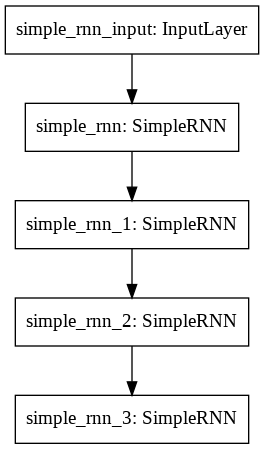

In [ ]:
tf.keras.utils.plot_model(model)

In [ ]:
N = 50 # Número de epochs
model.compile(loss="mse", 
              optimizer="adam",
              metrics=['mae', 'mse'])

history = model.fit(X_train, y_train, 
                    epochs=N,
                    batch_size=512,
                    validation_data=(X_valid, y_valid)
                    )

Epoch 1/50
526/526 [==============================] - 20s 32ms/step - loss: 0.0027 - mae: 0.0272 - mse: 0.0027 - val_loss: 2.6976e-04 - val_mae: 0.0102 - val_mse: 2.6976e-04
Epoch 2/50
526/526 [==============================] - 16s 31ms/step - loss: 2.4018e-04 - mae: 0.0089 - mse: 2.4018e-04 - val_loss: 1.9620e-04 - val_mae: 0.0089 - val_mse: 1.9620e-04
Epoch 3/50
526/526 [==============================] - 16s 30ms/step - loss: 1.8483e-04 - mae: 0.0082 - mse: 1.8483e-04 - val_loss: 1.6023e-04 - val_mae: 0.0079 - val_mse: 1.6023e-04
Epoch 4/50
526/526 [==============================] - 16s 30ms/step - loss: 1.5955e-04 - mae: 0.0080 - mse: 1.5955e-04 - val_loss: 1.8069e-04 - val_mae: 0.0103 - val_mse: 1.8069e-04
Epoch 5/50
526/526 [==============================] - 16s 31ms/step - loss: 1.2941e-04 - mae: 0.0072 - mse: 1.2941e-04 - val_loss: 1.2140e-04 - val_mae: 0.0079 - val_mse: 1.2140e-04
Epoch 6/50
526/526 [==============================] - 16s 30ms/step - loss: 9.8702e-05 - mae: 0.00

#**Results**

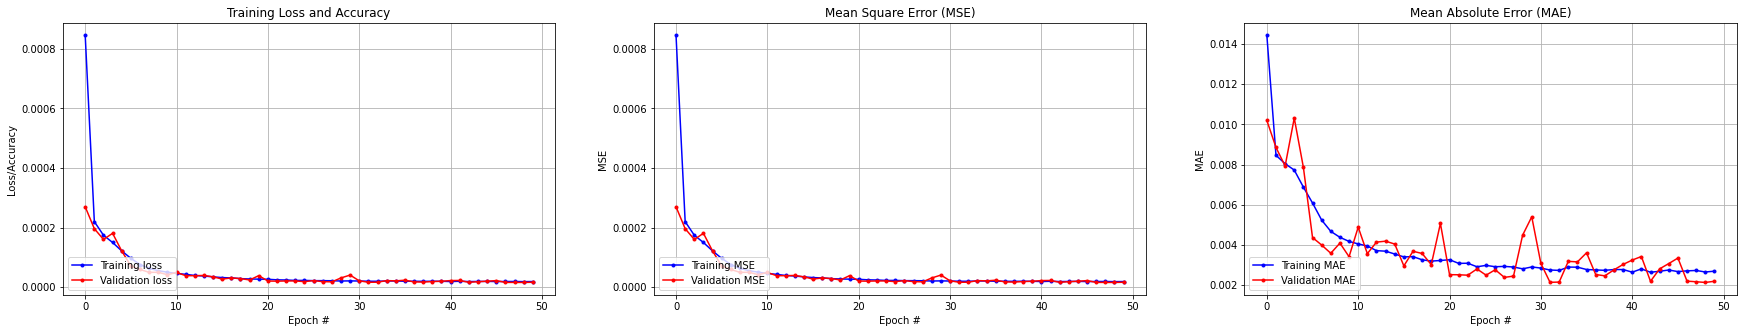

In [ ]:
plt.figure(figsize=(30,5))
plt.subplot(131)
plt.plot(np.arange(0, N), history.history["loss"], "b.-", label="Training loss")
plt.plot(np.arange(0, N), history.history["val_loss"],"r.-", label="Validation loss")
plt.title("Training Loss and Accuracy")
plt.xlabel("Epoch #")
plt.ylabel("Loss/Accuracy")
plt.legend(loc="lower left")
plt.grid()

plt.subplot(132)
plt.plot(np.arange(0, N), history.history["mse"], "b.-", label="Training MSE")
plt.plot(np.arange(0, N), history.history["val_mse"], "r.-", label="Validation MSE")
plt.title("Mean Square Error (MSE)")
plt.xlabel("Epoch #")
plt.ylabel("MSE")
plt.legend(loc="lower left")
plt.grid()

plt.subplot(133)
plt.plot(np.arange(0, N), history.history["mae"], "b.-", label="Training MAE")
plt.plot(np.arange(0, N), history.history["val_mae"], "r.-", label="Validation MAE")
plt.title("Mean Absolute Error (MAE)")
plt.xlabel("Epoch #")
plt.ylabel("MAE")
plt.legend(loc="lower left")
plt.grid()

plt.show()

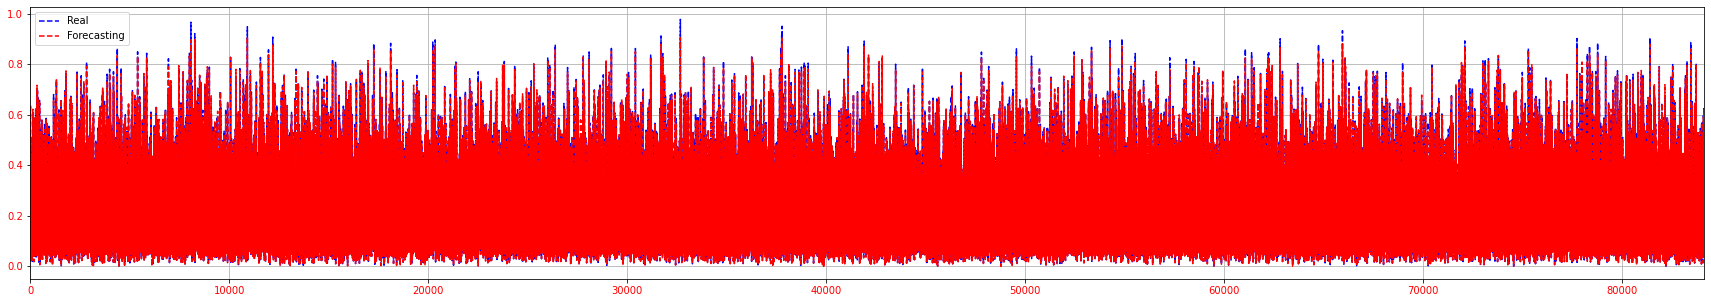

In [ ]:
forecasting = model.predict(X_test)

plt.figure(figsize=(30,5))
plt.plot(y_test, c='b', label='Real', linestyle='--')
plt.plot(forecasting, c='r', label='Forecasting', linestyle='--')
plt.xlim(0,len(y_test))
plt.xticks(c='r')
plt.yticks(c='r')
plt.grid(True)
plt.legend()
plt.show()

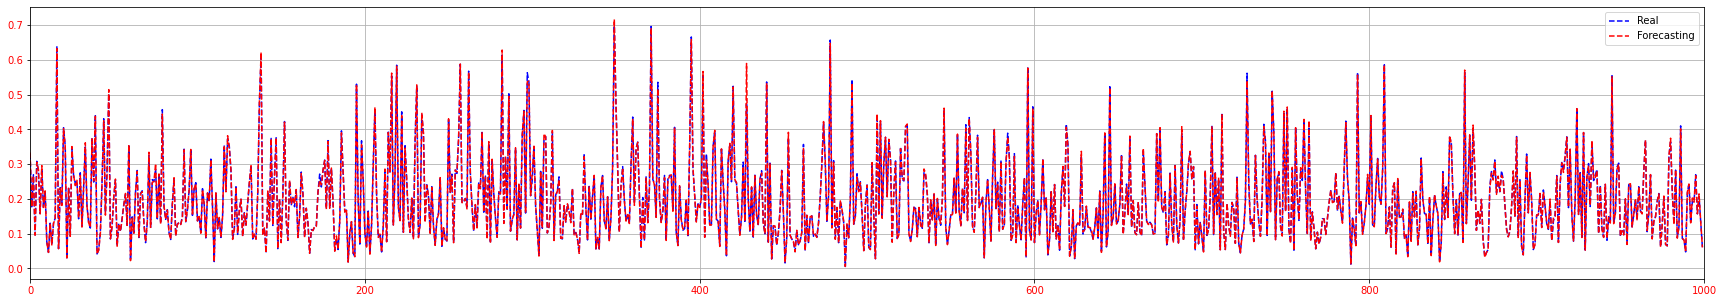

In [ ]:
# Fragmento de los datos
plt.figure(figsize=(30,5))
plt.plot(y_test[0:1000], c='b', label='Real', linestyle='--')
plt.plot(forecasting[0:1000], c='r', label='Forecasting', linestyle='--')
plt.xlim(0,1000)
plt.xticks(c='r')
plt.yticks(c='r')
plt.grid(True)
plt.legend()
plt.show()

In [ ]:
print("Mean Square Error (MSE): {}".format(mean_squared_error(y_test, forecasting, squared=False)))
print("Root Mean Square Error (MSE): {}".format(mean_squared_error(y_test, forecasting, squared=True)))
print("Mean Absolute Error (MAE): {}".format(mean_absolute_error(y_test, forecasting)))
print("R2: {}".format(r2_score(y_test, forecasting)))


Mean Square Error (MSE): 0.004179060469029905
Root Mean Square Error (MSE): 1.7464546403808454e-05
Mean Absolute Error (MAE): 0.002199520990026002
R2: 0.9988485217637604
